In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [2]:
file = open("data1.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  ﻿One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


# Data Cleaning

In [3]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:400]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.  His many legs, pitifully thin compared'

In [4]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [5]:
q = []

for i in data.split():
    if i not in q:
        q.append(i)
        
data = ' '.join(q)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

# Tockenisation

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[17, 53, 293, 2, 18, 729, 135, 730, 294, 8, 731, 19, 732, 9, 295]

In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [8]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:5]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729]])

In [9]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [10]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 17  53 293   2  18]
The responses are:  [ 53 293   2  18 729]


In [11]:
max_sequence_len = max([len(X) for x in sequences])
input_sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0, ...,   0,  53, 293])

In [12]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=1))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 100)            261700    
                                                                 
 lstm (LSTM)                 (None, 1, 100)            80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 2617)              264317    
                                                                 
Total params: 696,917
Trainable params: 696,917
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

# Compile The Model

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

C:\Users\USER\anaconda3\envs\ML\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Fitting The Model

In [18]:
history=model.fit(X, y, epochs=200, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/200
59/61 [============================>.] - ETA: 0s - loss: 7.8743 - accuracy: 7.9449e-04
Epoch 1: loss improved from inf to 7.87442, saving model to nextword1.h5
61/61 [==============================] - 5s 17ms/step - loss: 7.8744 - accuracy: 7.7141e-04 - lr: 0.0010
Epoch 2/200
59/61 [============================>.] - ETA: 0s - loss: 7.8650 - accuracy: 0.0026
Epoch 2: loss improved from 7.87442 to 7.86500, saving model to nextword1.h5
61/61 [==============================] - 1s 17ms/step - loss: 7.8650 - accuracy: 0.0026 - lr: 0.0010
Epoch 3/200
60/61 [============================>.] - ETA: 0s - loss: 7.8586 - accuracy: 0.0039
Epoch 3: loss improved from 7.86500 to 7.85844, saving model to nextword1.h5
61/61 [==============================] - 1s 17ms/step - loss: 7.8584 - accuracy: 0.0039 - lr: 0.0010
Epoch 4/200
58/61 [===========================>..] - ETA: 0s - loss: 7.7446 - accuracy: 0.0027
Epoch 4: loss improved from 7.85844 to 7.74679, saving model to nextword1.h5
61/61

Epoch 31/200
61/61 [==============================] - ETA: 0s - loss: 4.9360 - accuracy: 0.0244
Epoch 31: loss improved from 5.05216 to 4.93603, saving model to nextword1.h5
61/61 [==============================] - 1s 21ms/step - loss: 4.9360 - accuracy: 0.0244 - lr: 0.0010
Epoch 32/200
61/61 [==============================] - ETA: 0s - loss: 4.8330 - accuracy: 0.0249
Epoch 32: loss improved from 4.93603 to 4.83304, saving model to nextword1.h5
61/61 [==============================] - 1s 21ms/step - loss: 4.8330 - accuracy: 0.0249 - lr: 0.0010
Epoch 33/200
61/61 [==============================] - ETA: 0s - loss: 4.7512 - accuracy: 0.0249
Epoch 33: loss improved from 4.83304 to 4.75118, saving model to nextword1.h5
61/61 [==============================] - 2s 35ms/step - loss: 4.7512 - accuracy: 0.0249 - lr: 0.0010
Epoch 34/200
61/61 [==============================] - ETA: 0s - loss: 4.6614 - accuracy: 0.0296
Epoch 34: loss improved from 4.75118 to 4.66137, saving model to nextword1.h5
6

Epoch 61/200
61/61 [==============================] - ETA: 0s - loss: 3.3444 - accuracy: 0.1206
Epoch 61: loss improved from 3.38903 to 3.34437, saving model to nextword1.h5
61/61 [==============================] - 1s 22ms/step - loss: 3.3444 - accuracy: 0.1206 - lr: 0.0010
Epoch 62/200
61/61 [==============================] - ETA: 0s - loss: 3.2934 - accuracy: 0.1209
Epoch 62: loss improved from 3.34437 to 3.29342, saving model to nextword1.h5
61/61 [==============================] - 1s 22ms/step - loss: 3.2934 - accuracy: 0.1209 - lr: 0.0010
Epoch 63/200
60/61 [============================>.] - ETA: 0s - loss: 3.2575 - accuracy: 0.1333
Epoch 63: loss improved from 3.29342 to 3.26039, saving model to nextword1.h5
61/61 [==============================] - 1s 24ms/step - loss: 3.2604 - accuracy: 0.1327 - lr: 0.0010
Epoch 64/200
61/61 [==============================] - ETA: 0s - loss: 3.2249 - accuracy: 0.1332
Epoch 64: loss improved from 3.26039 to 3.22490, saving model to nextword1.h5
6

Epoch 91/200
61/61 [==============================] - ETA: 0s - loss: 2.1927 - accuracy: 0.3224
Epoch 91: loss improved from 2.23525 to 2.19272, saving model to nextword1.h5
61/61 [==============================] - 1s 17ms/step - loss: 2.1927 - accuracy: 0.3224 - lr: 0.0010
Epoch 92/200
60/61 [============================>.] - ETA: 0s - loss: 2.1406 - accuracy: 0.3320
Epoch 92: loss improved from 2.19272 to 2.14297, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 2.1430 - accuracy: 0.3312 - lr: 0.0010
Epoch 93/200
61/61 [==============================] - ETA: 0s - loss: 2.1031 - accuracy: 0.3466
Epoch 93: loss improved from 2.14297 to 2.10311, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 2.1031 - accuracy: 0.3466 - lr: 0.0010
Epoch 94/200
61/61 [==============================] - ETA: 0s - loss: 2.0719 - accuracy: 0.3492
Epoch 94: loss improved from 2.10311 to 2.07187, saving model to nextword1.h5
6

Epoch 121/200
61/61 [==============================] - ETA: 0s - loss: 1.3387 - accuracy: 0.5040
Epoch 121: loss improved from 1.35520 to 1.33873, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 1.3387 - accuracy: 0.5040 - lr: 0.0010
Epoch 122/200
61/61 [==============================] - ETA: 0s - loss: 1.3269 - accuracy: 0.5145
Epoch 122: loss improved from 1.33873 to 1.32686, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 1.3269 - accuracy: 0.5145 - lr: 0.0010
Epoch 123/200
60/61 [============================>.] - ETA: 0s - loss: 1.3225 - accuracy: 0.5065
Epoch 123: loss improved from 1.32686 to 1.32505, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 1.3250 - accuracy: 0.5058 - lr: 0.0010
Epoch 124/200
61/61 [==============================] - ETA: 0s - loss: 1.2961 - accuracy: 0.5174
Epoch 124: loss improved from 1.32505 to 1.29614, saving model to nextwo

Epoch 151/200
60/61 [============================>.] - ETA: 0s - loss: 0.9888 - accuracy: 0.5729
Epoch 151: loss improved from 0.99458 to 0.99201, saving model to nextword1.h5
61/61 [==============================] - 1s 17ms/step - loss: 0.9920 - accuracy: 0.5721 - lr: 0.0010
Epoch 152/200
61/61 [==============================] - ETA: 0s - loss: 0.9861 - accuracy: 0.5721
Epoch 152: loss improved from 0.99201 to 0.98614, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 0.9861 - accuracy: 0.5721 - lr: 0.0010
Epoch 153/200
60/61 [============================>.] - ETA: 0s - loss: 0.9790 - accuracy: 0.5742
Epoch 153: loss improved from 0.98614 to 0.98372, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 0.9837 - accuracy: 0.5726 - lr: 0.0010
Epoch 154/200
61/61 [==============================] - ETA: 0s - loss: 0.9981 - accuracy: 0.5631
Epoch 154: loss did not improve from 0.98372
61/61 [====================

Epoch 181/200
61/61 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.5801
Epoch 181: loss improved from 0.69483 to 0.69475, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 0.6947 - accuracy: 0.5801 - lr: 2.0000e-04
Epoch 182/200
61/61 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.5796
Epoch 182: loss improved from 0.69475 to 0.69428, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 0.6943 - accuracy: 0.5796 - lr: 2.0000e-04
Epoch 183/200
61/61 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5780
Epoch 183: loss improved from 0.69428 to 0.69387, saving model to nextword1.h5
61/61 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.5780 - lr: 2.0000e-04
Epoch 184/200
60/61 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5841
Epoch 184: loss did not improve from 0.69387
61/61 [========

In [19]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

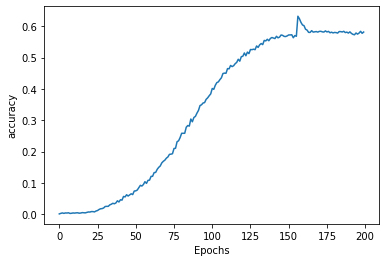

In [20]:
plot_graphs(history, 'accuracy')

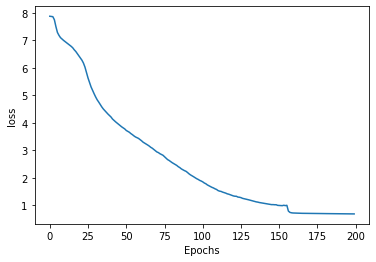

In [21]:
plot_graphs(history, 'loss')

# Making Predictions

In [12]:
max_sequence_len = max([len(X) for x in sequences])
input_sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0, ...,   0,  53, 293])

In [13]:
# Importing the Libraries

from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer

model = load_model('nextword1.h5')
tokenizer = pickle.load(open('tokenizer1.pkl', 'rb'))


In [ ]:

while(True):
    seed_text = input("Enter your line: ")
  
    if seed_text == "0":
        print("Execution completed.....")
        break

    else:
        try:
            next_words = 2
            suggested_word = []
            #temp = seed_text
            for _ in range(next_words):
                
                token_list = tokenizer.texts_to_sequences([seed_text])[0]
                #print(token_list)
                token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
                predicted = np.argmax(model.predict(token_list), axis=-1)
                output_word = ""
                
                for word, index in tokenizer.word_index.items():
                    if index == predicted:
                        output_word = word
                        suggested_word.append(output_word)
                        break
                
                seed_text += " " + output_word
            print("Suggested next two word are : ",suggested_word)
            #n = int(input())
            
            print(seed_text)
        except Exception as e:
            print("Error occurred: ",e)
        continue

Enter your line: In the morning I
Suggested next two word are :  ['bearing', 'visible']
In the morning I bearing visible
